In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## loading the Data 

source https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset

In [31]:
df = pd.read_csv(
  "london_bike_sharing.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


The data from cycling dataset is grouped by "Start time", this represent the count of new bike shares grouped by hour. The long duration shares are not taken in the count.

Metadata:
"timestamp" - timestamp field for grouping the data
"cnt" - the count of a new bike shares
"t1" - real temperature in C
"t2" - temperature in C "feels like"
"hum" - humidity in percentage
"wind_speed" - wind speed in km/h
"weather_code" - category of the weather
"is_holiday" - boolean field - 1 holiday / 0 non holiday
"is_weekend" - boolean field - 1 if the day is weekend
"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

"weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [32]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


## Autocorrelation function (ACF)
The autocorrelation function is a measure of the correlation between observations of a time series that are separated by k time units (yt and yt–k).

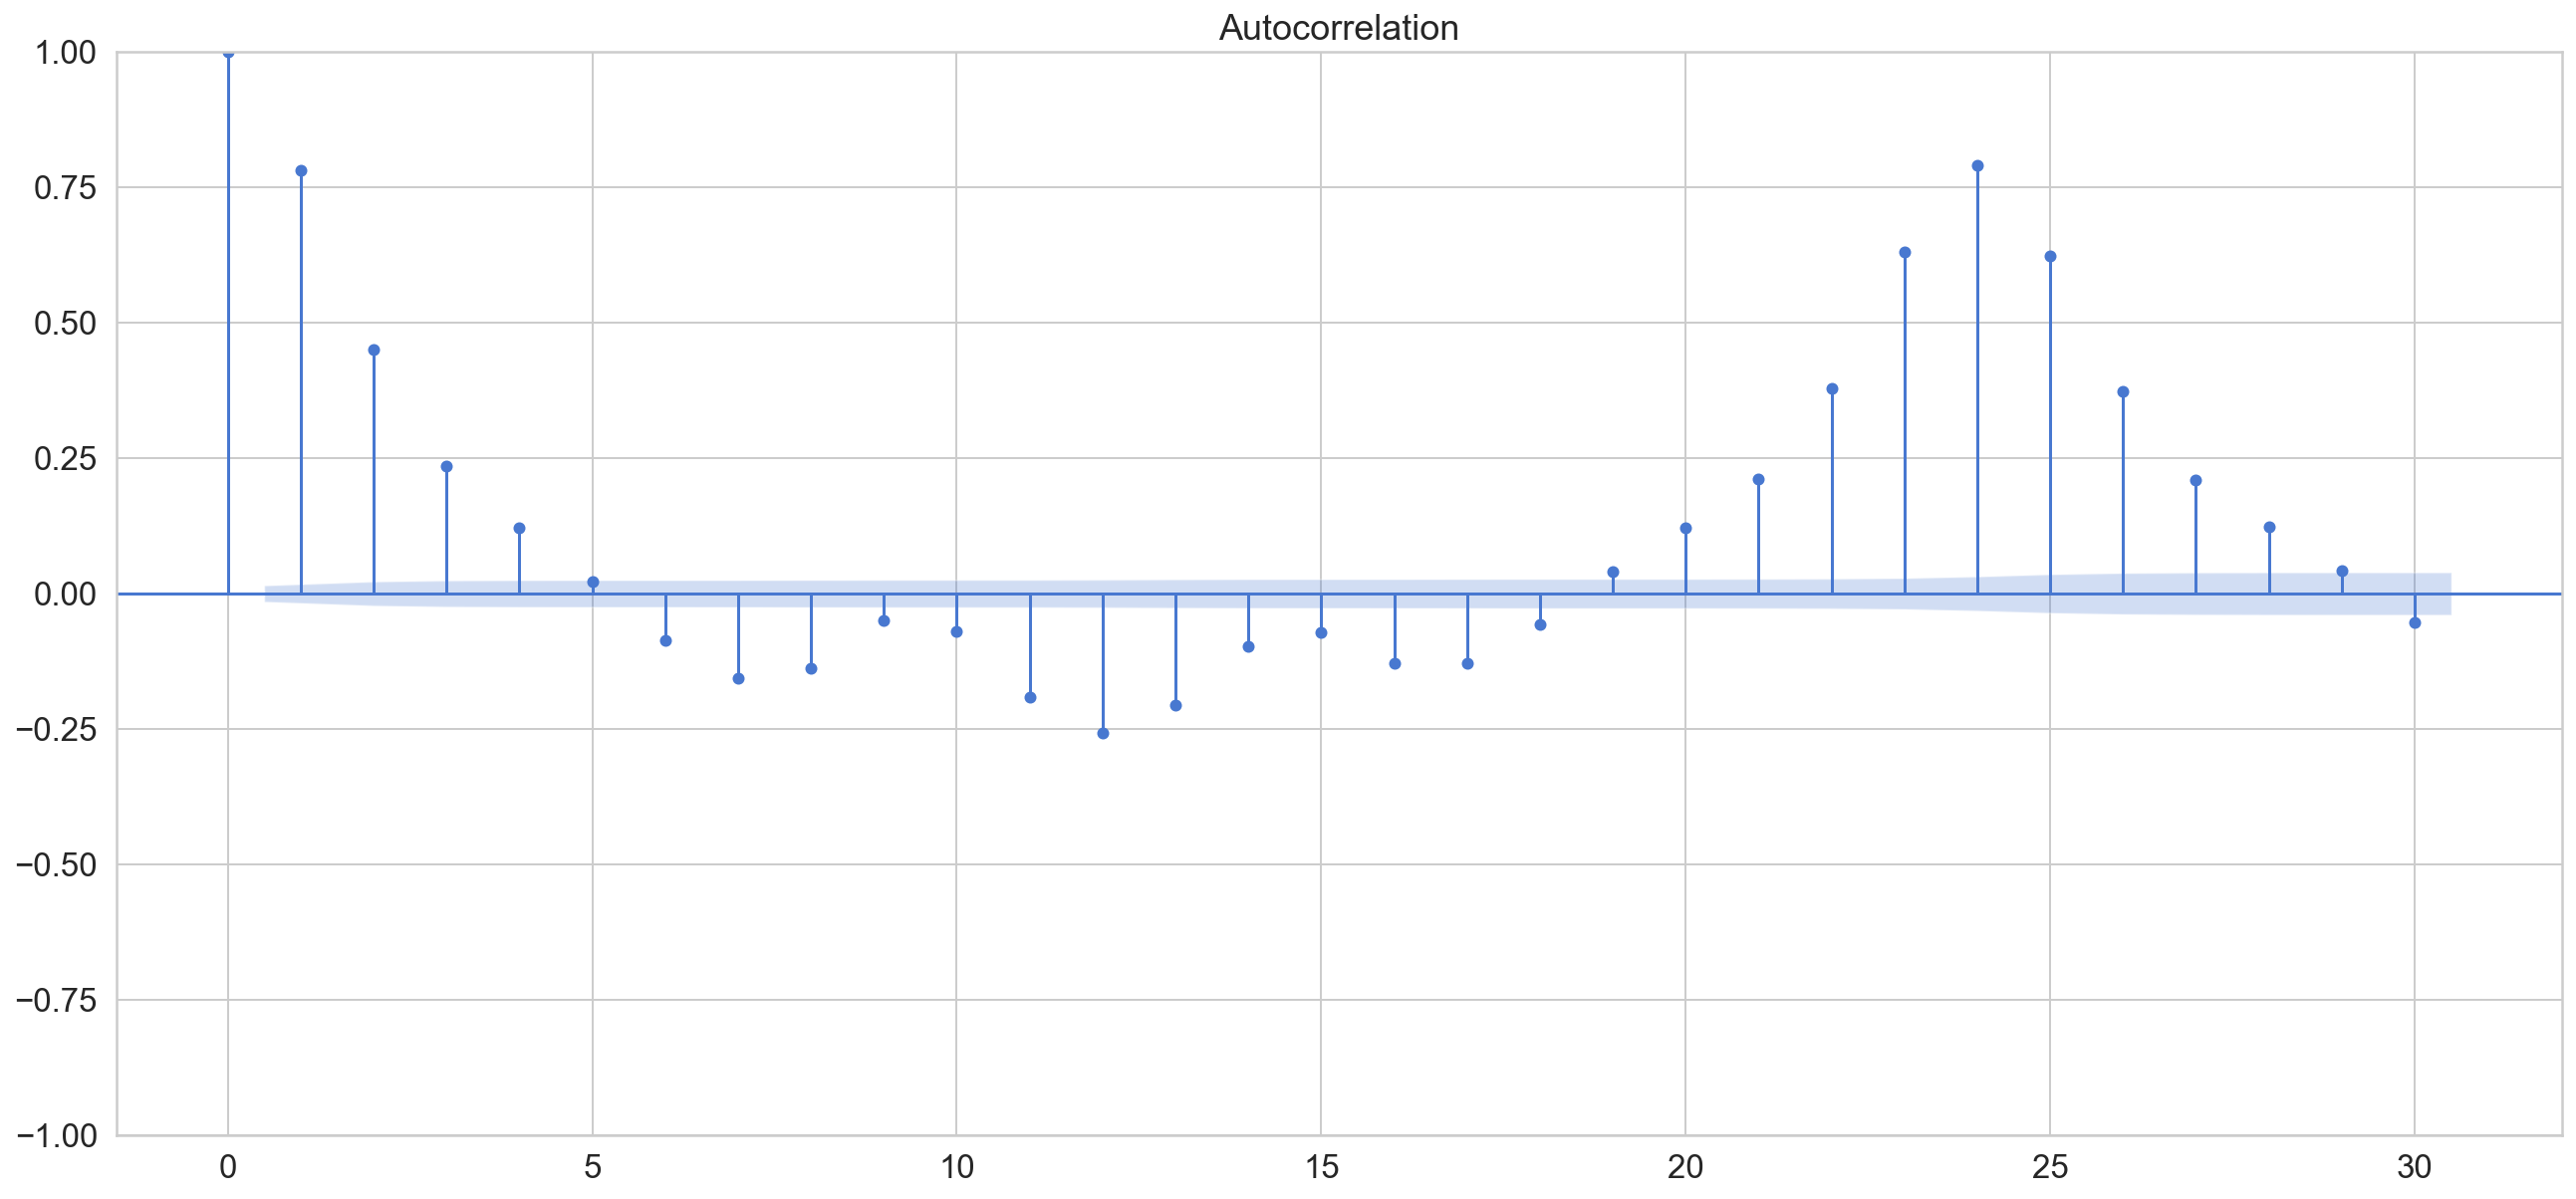

In [33]:
#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.
from statsmodels.graphics.tsaplots import plot_acf

# Calculate the ACF
acf = plot_acf(df.cnt, lags=30, alpha=.05)

# Plot the ACF
plt.show()

## Feature Engineering 

In [34]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    df['hour'] = df.index.hour
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

In [35]:
df = create_features(df)

In [36]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.00000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075,11.513265,15.751981,2.99265,6.514643
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911,6.915893,8.793704,2.00406,3.452509
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,1.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000,6.000000,8.000000,1.00000,4.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000,12.000000,16.000000,3.00000,7.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000,18.000000,23.000000,5.00000,10.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000,23.000000,31.000000,6.00000,12.000000


## Data  Visualization

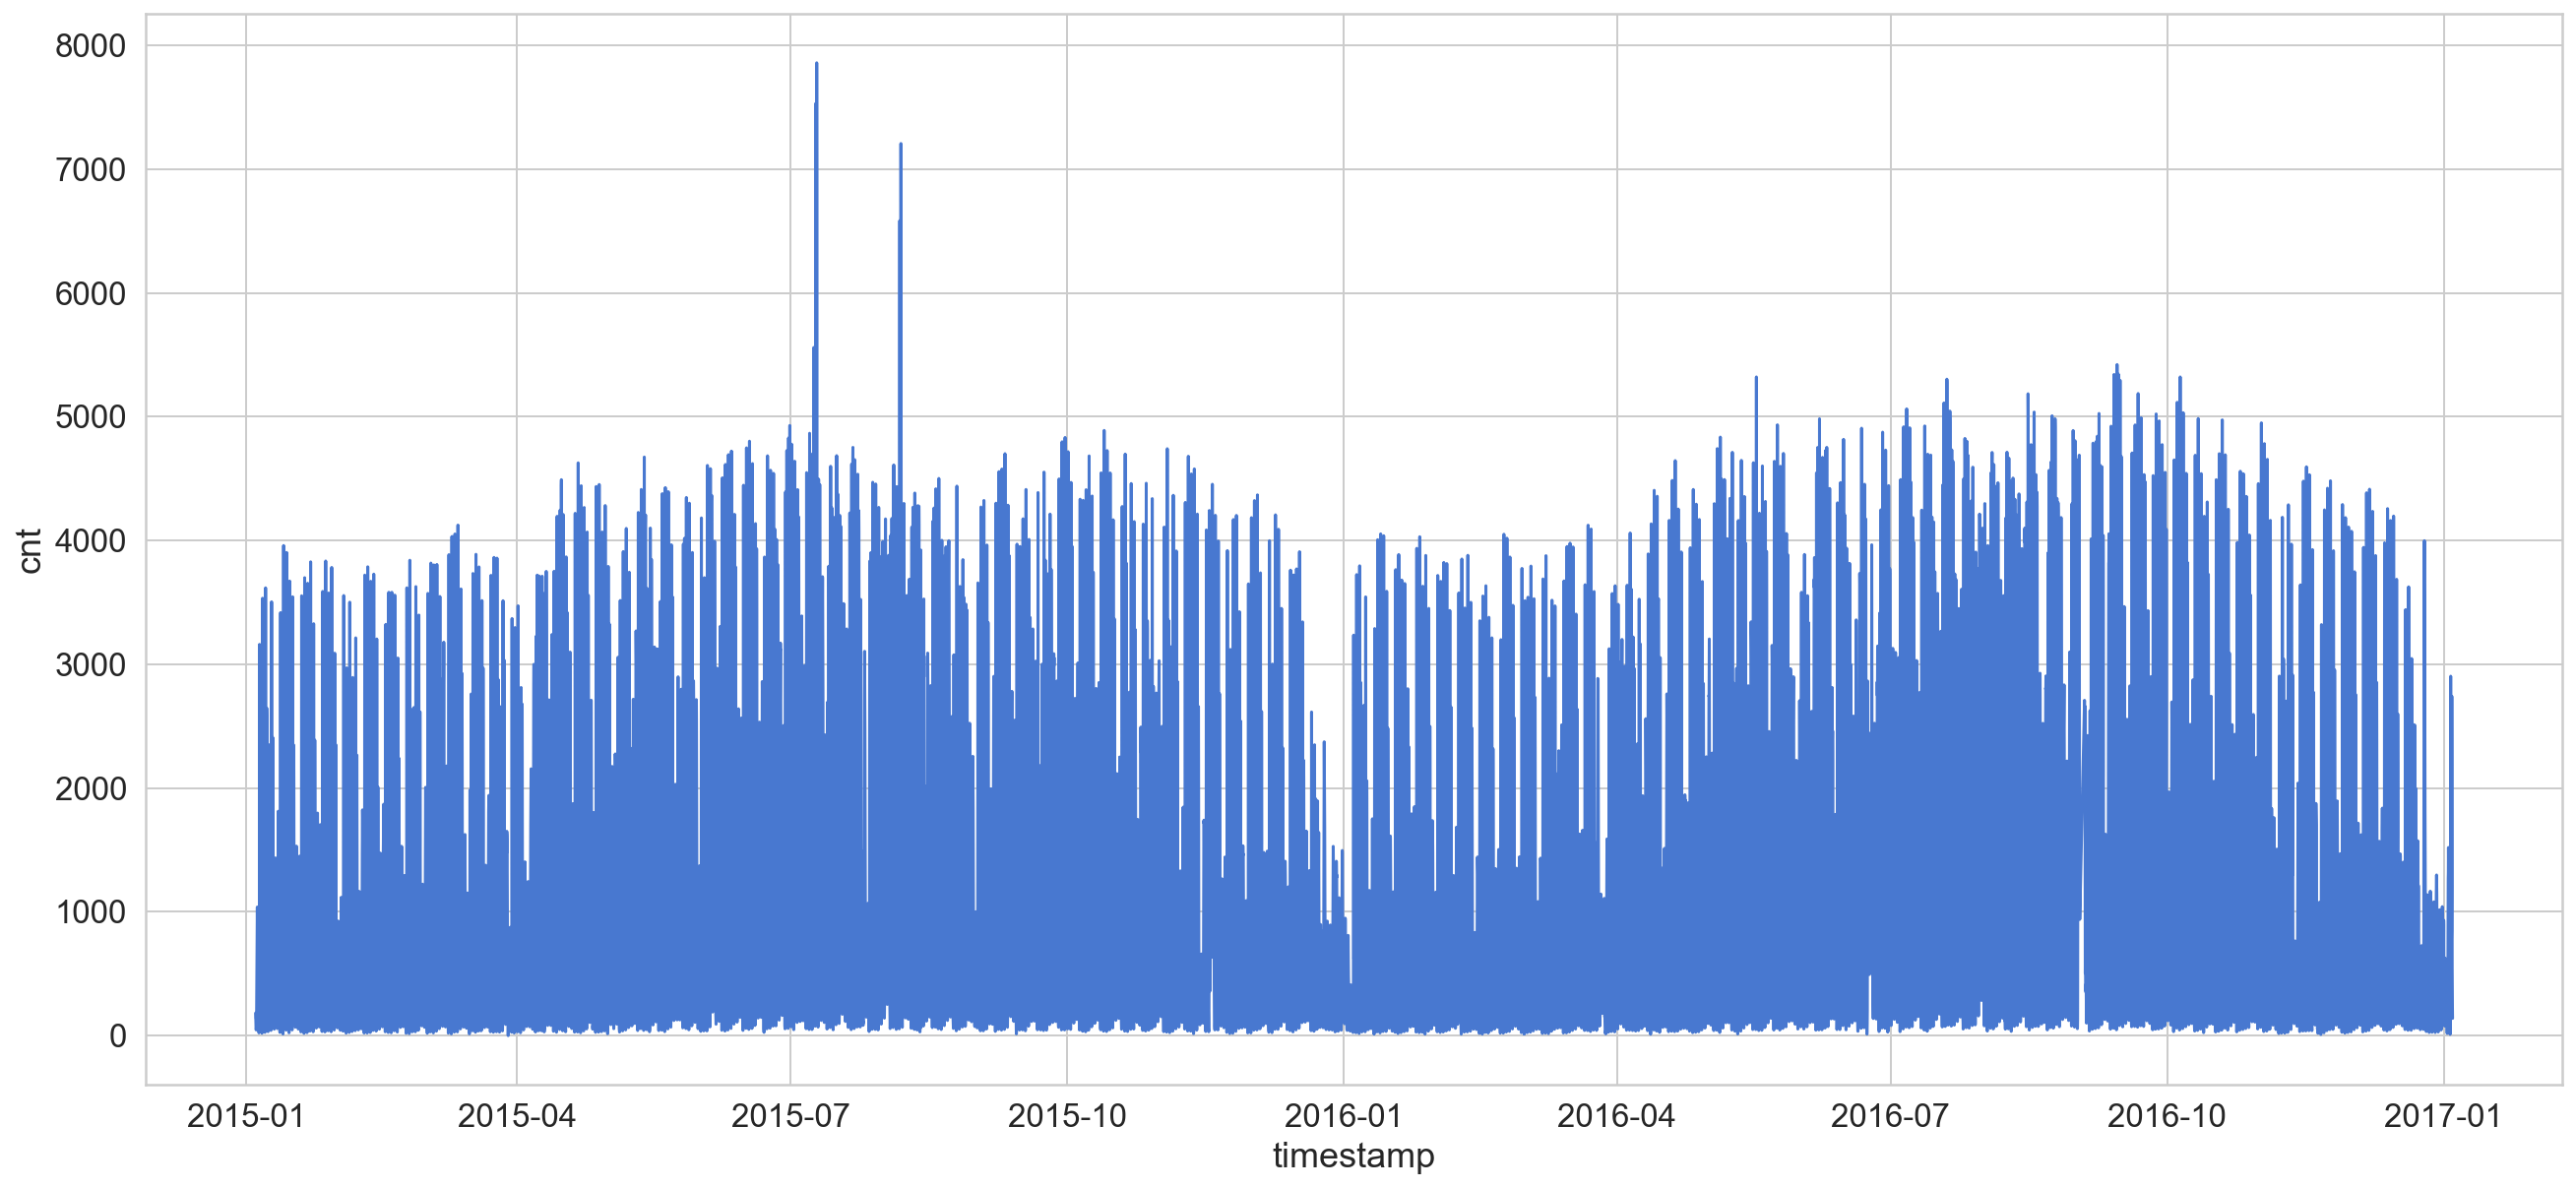

In [37]:
sns.lineplot(x=df.index, y="cnt", data=df);

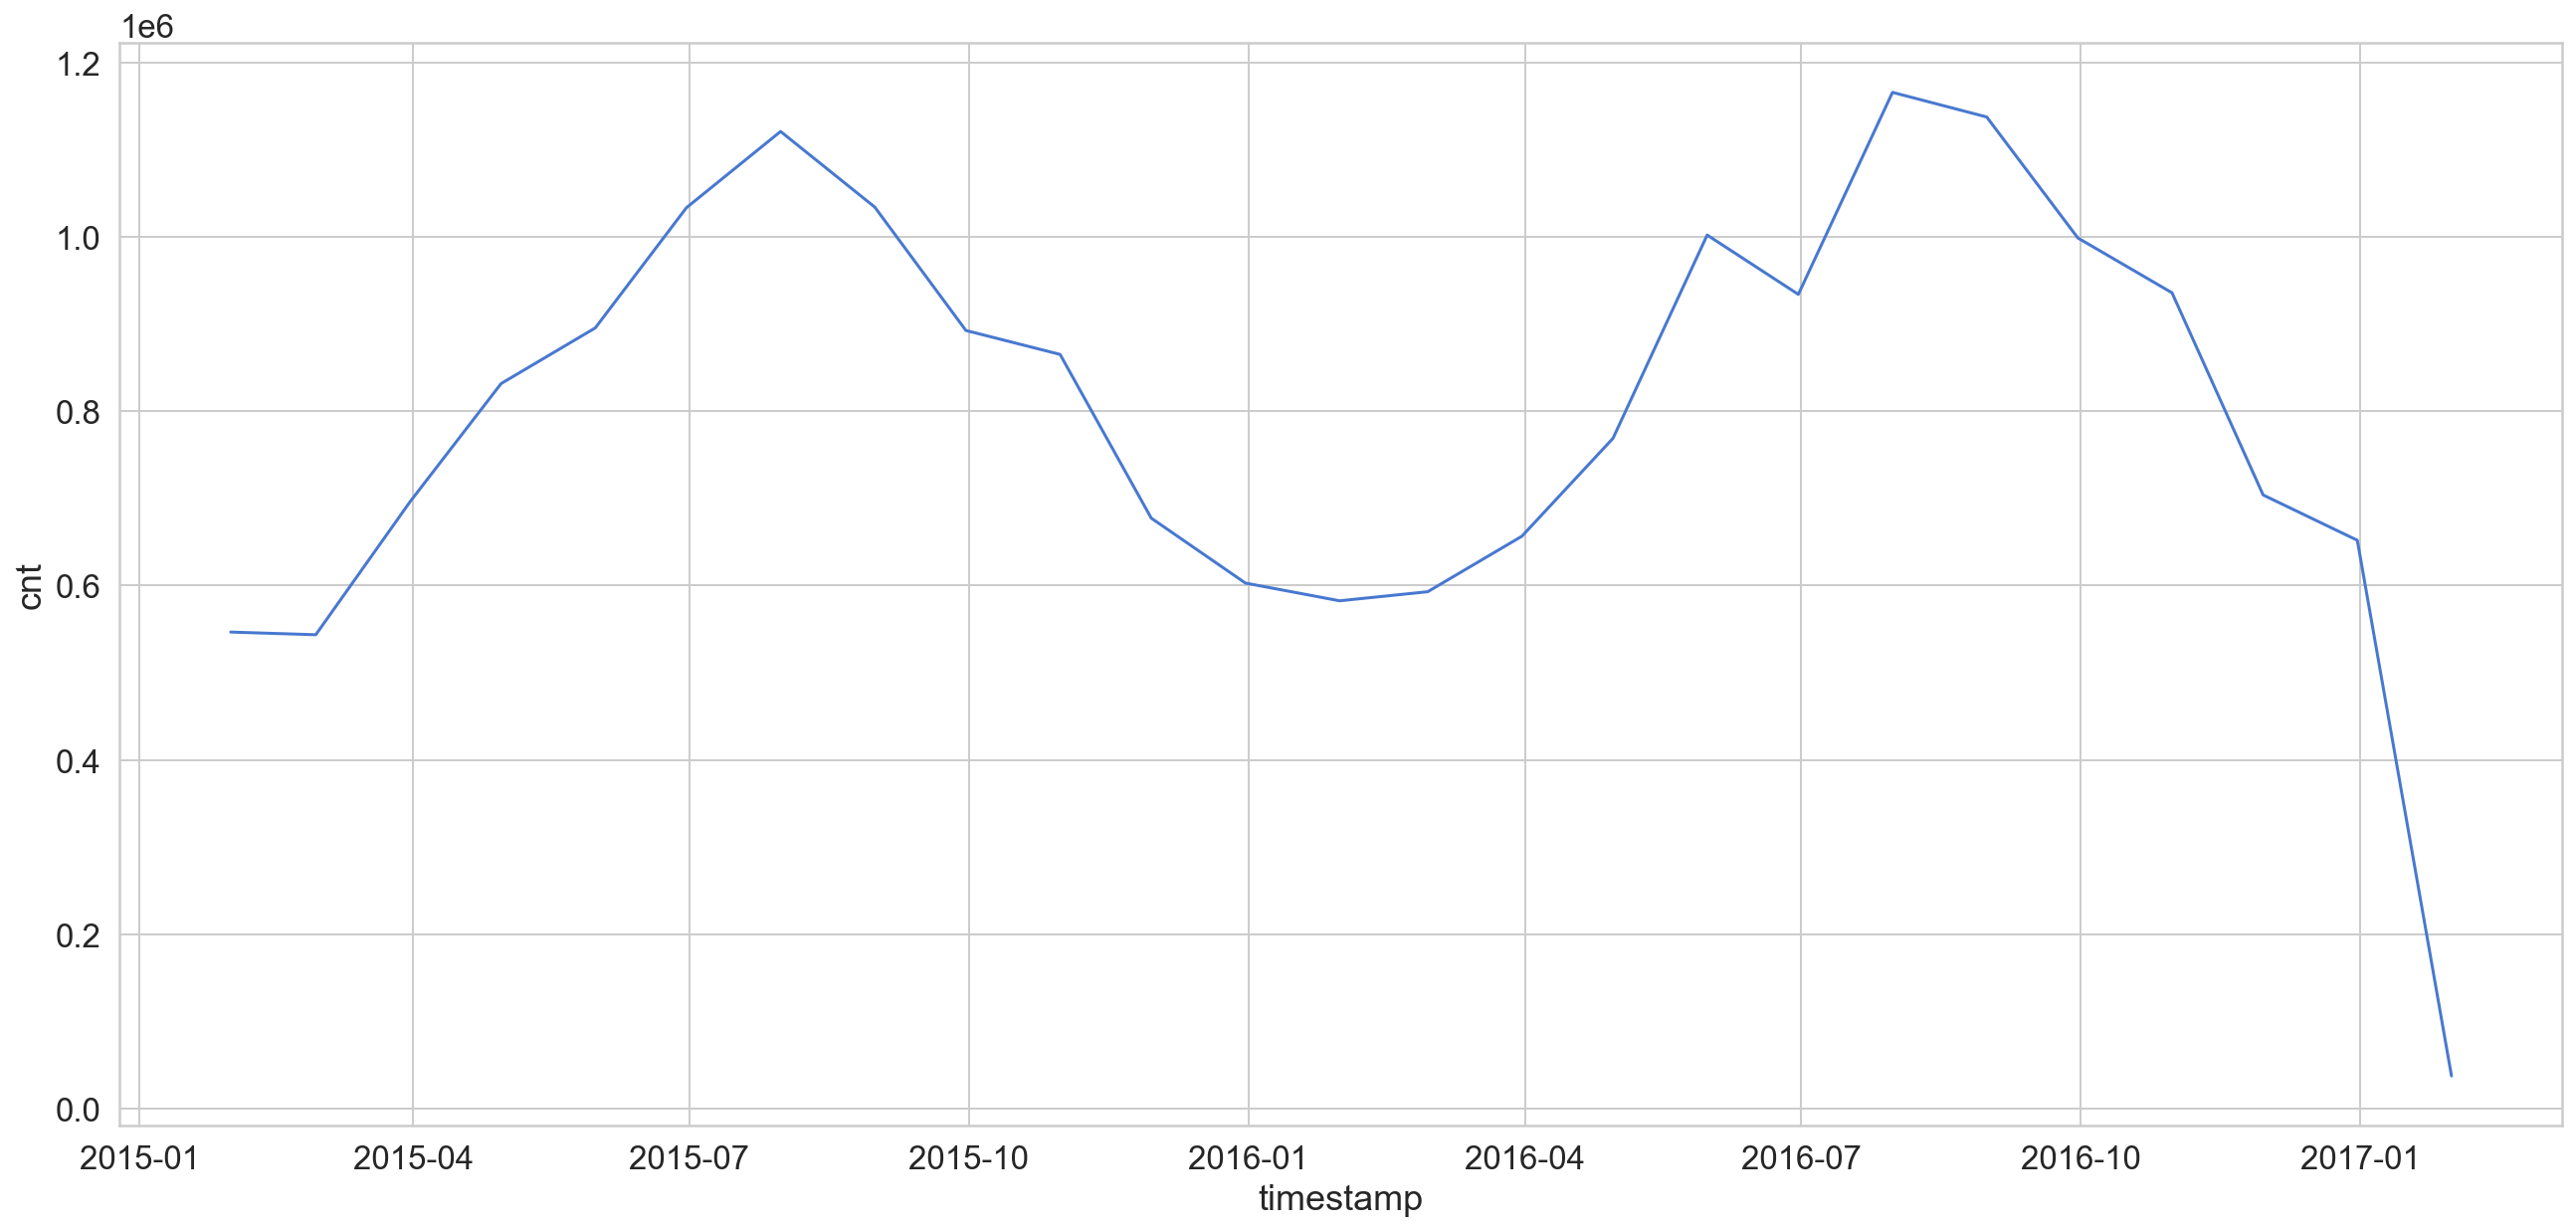

In [38]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

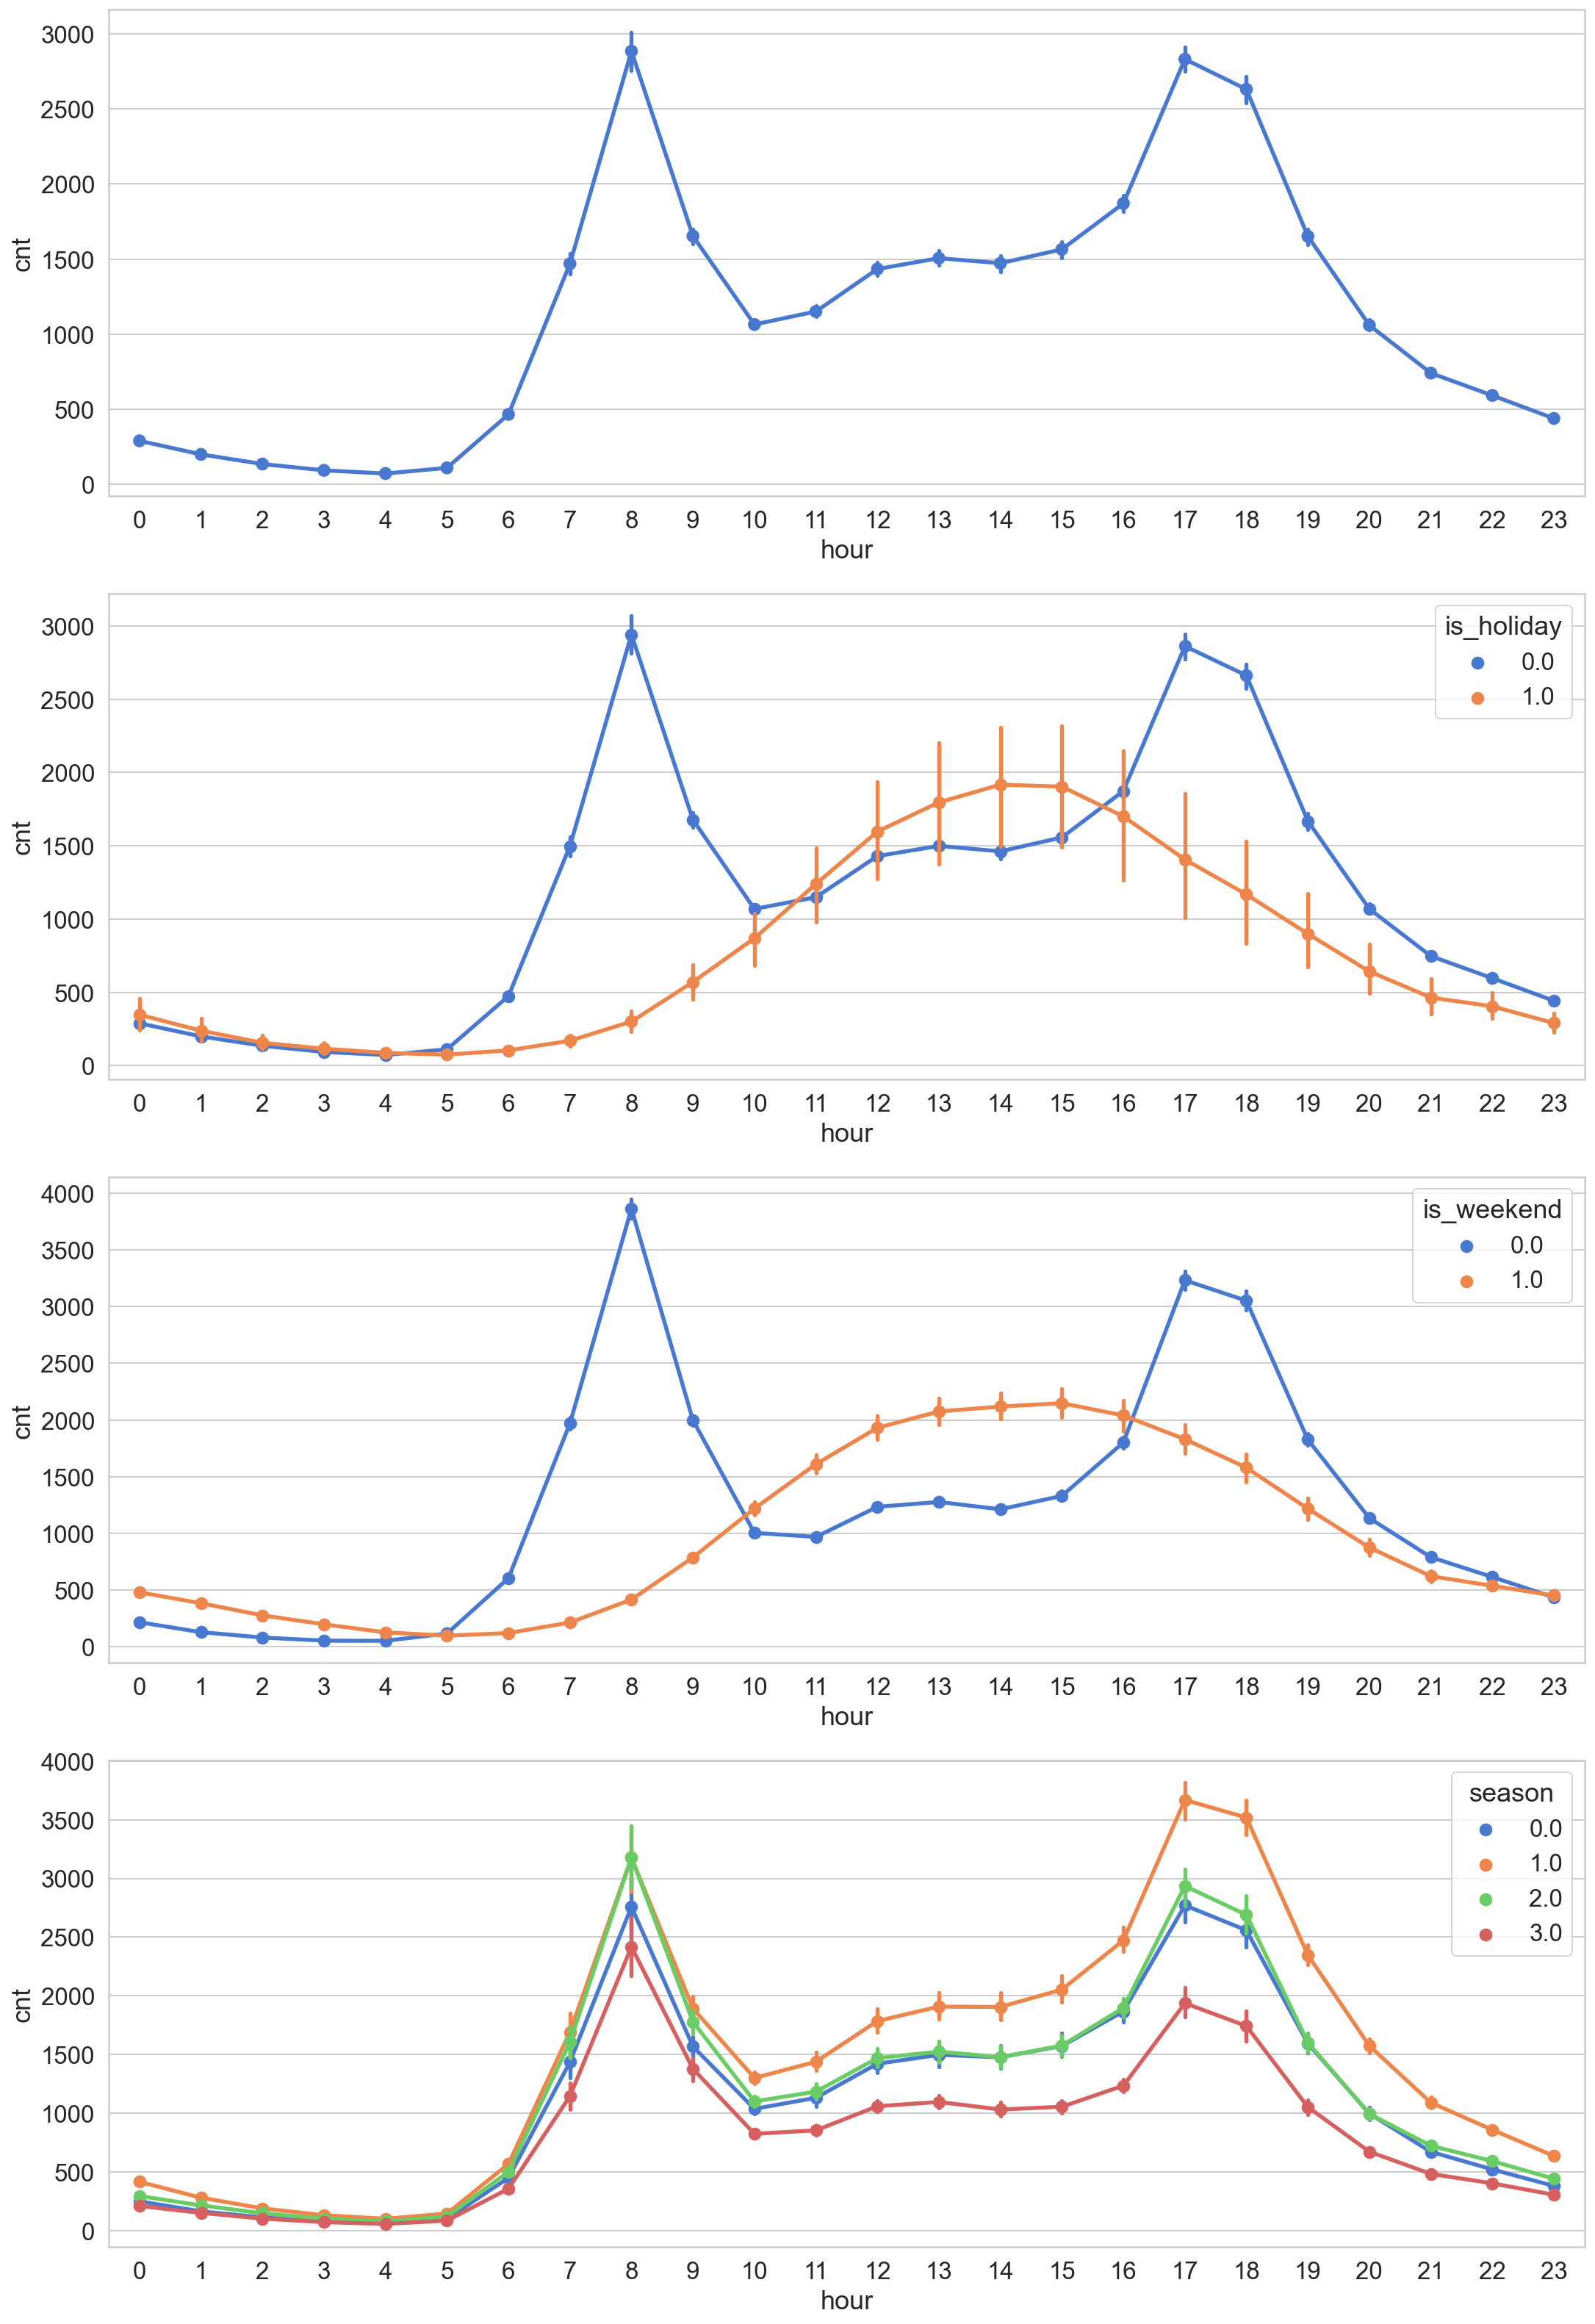

In [39]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

In [40]:
#Dickey-Fuller test
# df['timestamp'] = pd.to_datetime(df['timestamp'])
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['cnt'])

1. ADF :  -9.879284554122307
2. P-Value :  3.8080074576440877e-17
3. Num Of Lags :  41
4. Num Of Observations Used For ADF Regression: 17372
5. Critical Values :
	 1% :  -3.4307264832218953
	 5% :  -2.8617063909658196
	 10% :  -2.5668585656053984


array([[<AxesSubplot: title={'center': 'cnt'}>,
        <AxesSubplot: title={'center': 't1'}>,
        <AxesSubplot: title={'center': 't2'}>,
        <AxesSubplot: title={'center': 'hum'}>],
       [<AxesSubplot: title={'center': 'wind_speed'}>,
        <AxesSubplot: title={'center': 'weather_code'}>,
        <AxesSubplot: title={'center': 'is_holiday'}>,
        <AxesSubplot: title={'center': 'is_weekend'}>],
       [<AxesSubplot: title={'center': 'season'}>,
        <AxesSubplot: title={'center': 'hour'}>,
        <AxesSubplot: title={'center': 'day_of_month'}>,
        <AxesSubplot: title={'center': 'day_of_week'}>],
       [<AxesSubplot: title={'center': 'month'}>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

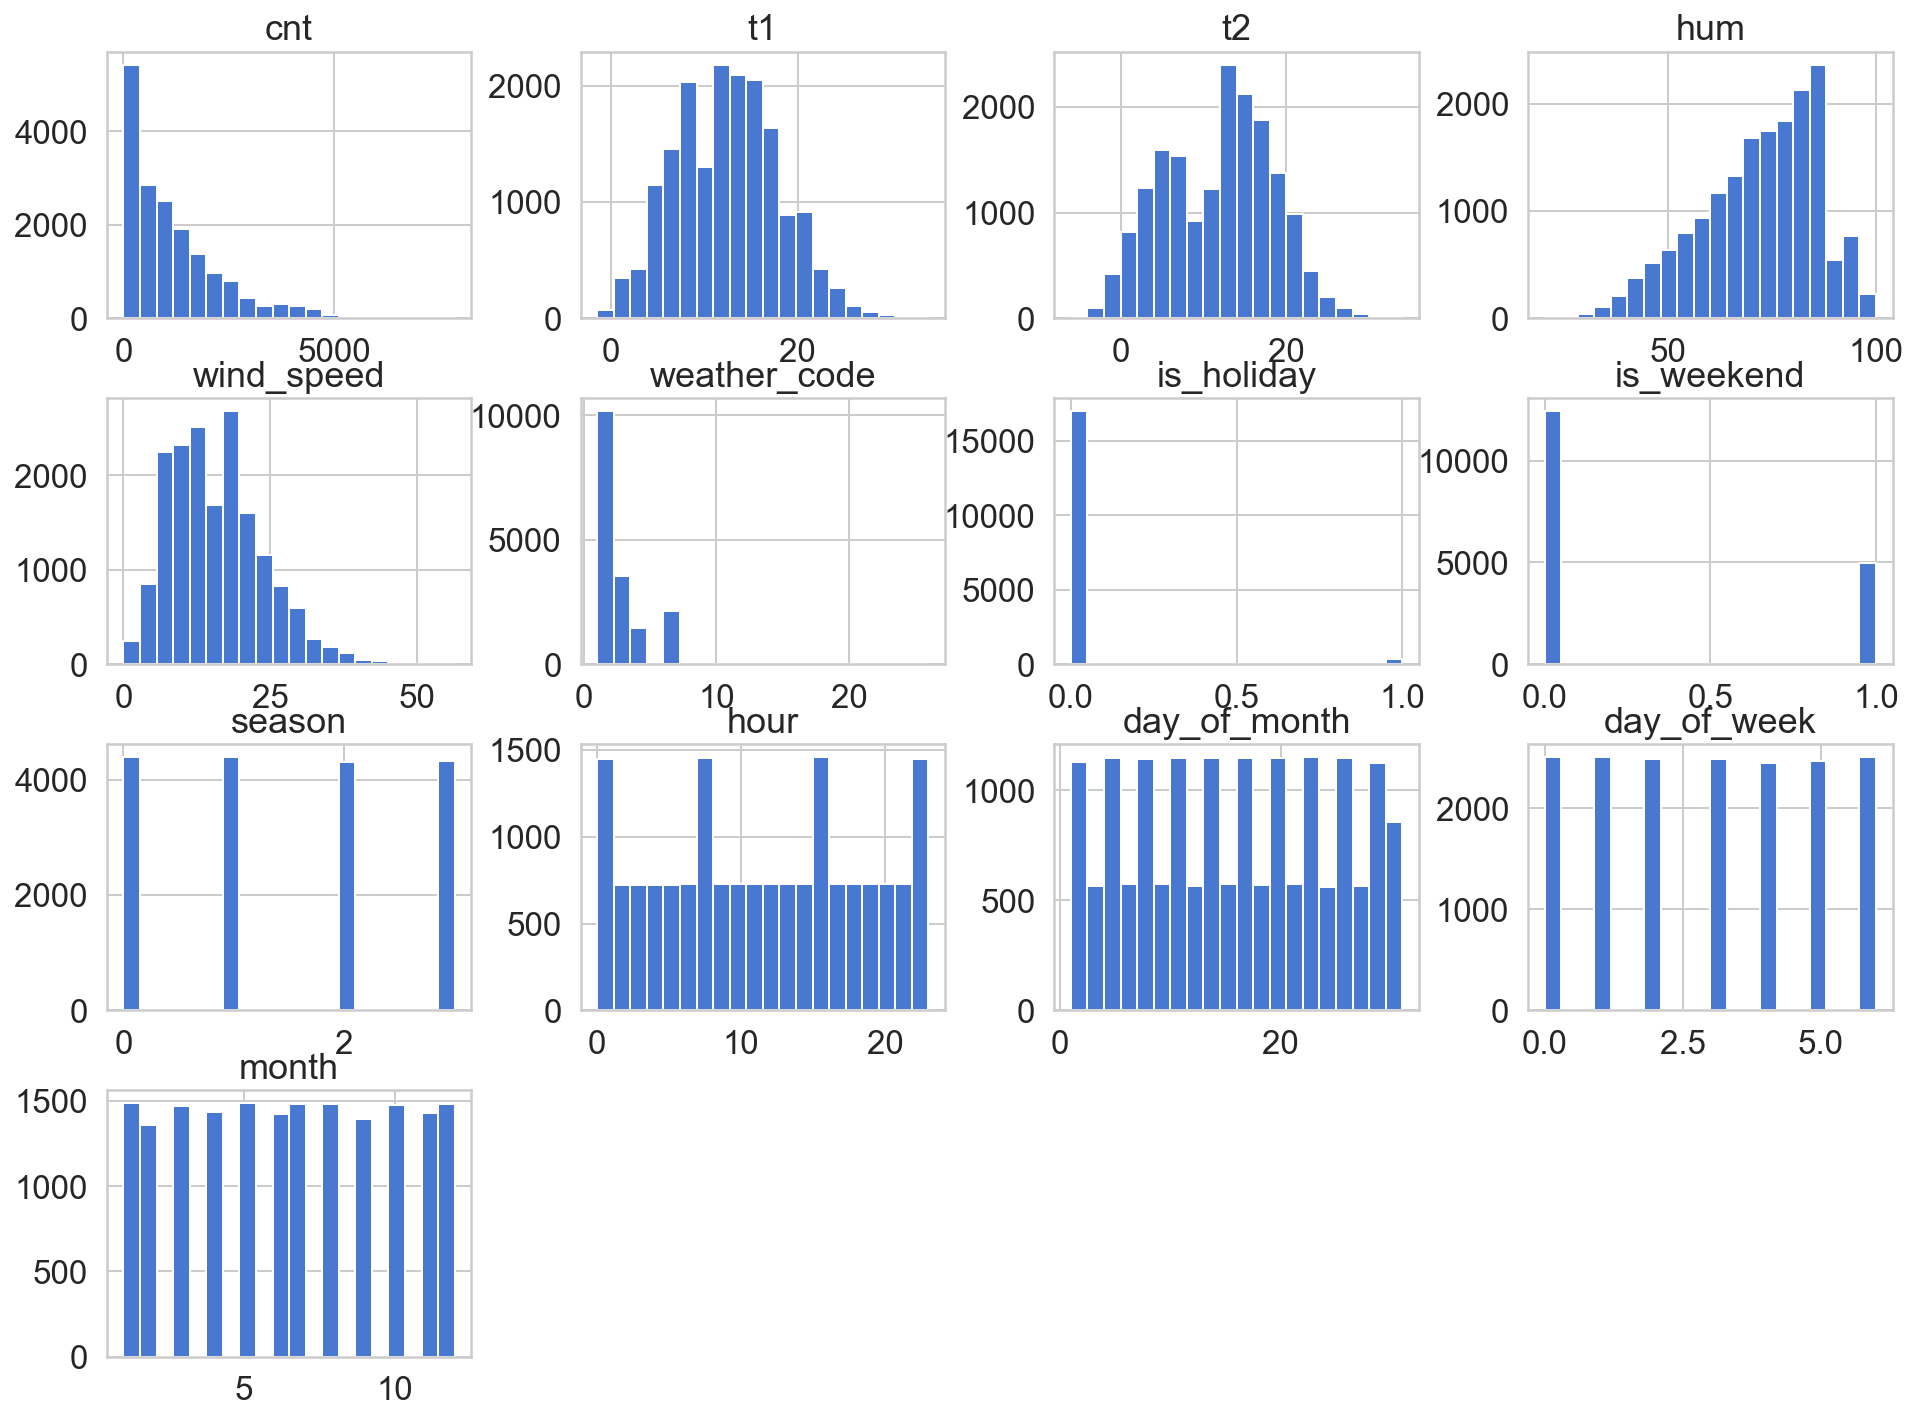

In [41]:
df.hist(bins=20, figsize=(16,12))

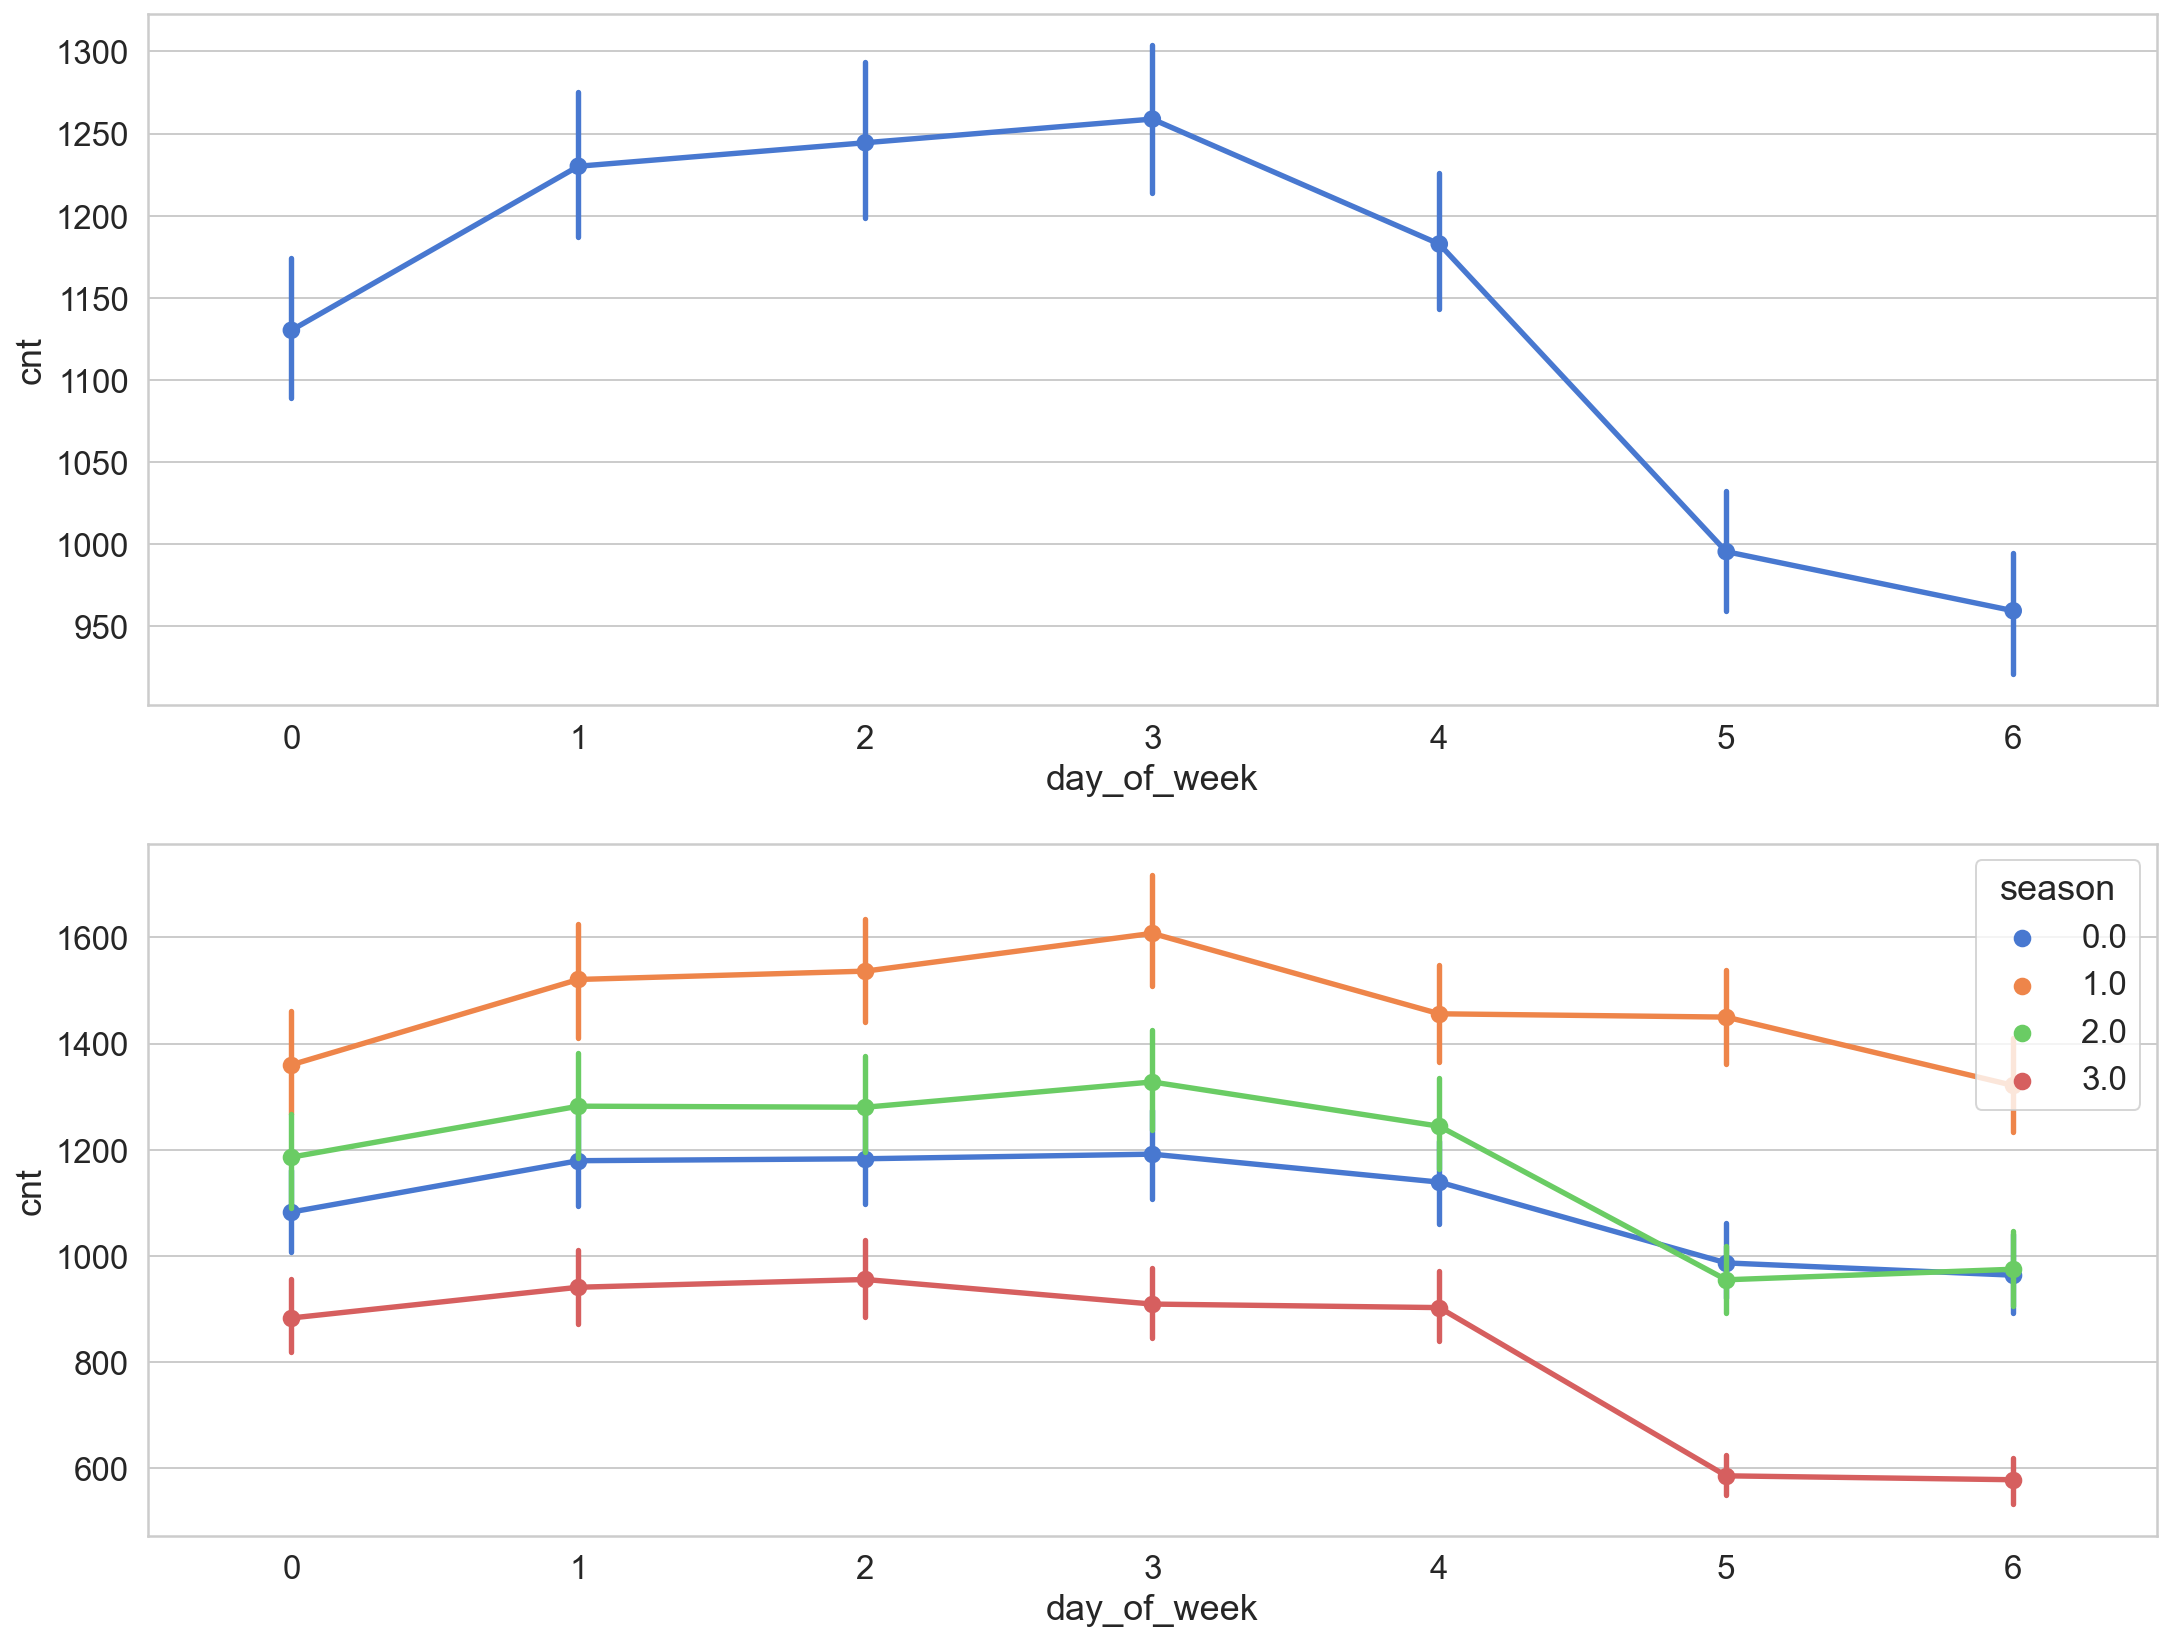

In [42]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

## Spilting the Data to Train and Testing 

In [43]:
train_size = int(len(df) * 0.9) # here i spilt the Data to Train and Test where the 90% of the Data is Train and the 10 % is the testing 
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


### Robust Scaling Data
it is common to scale data prior to fitting a machine learning model.

This is because data often consists of many different input variables or features (columns) and each may have a different range of values or units of measure, such as feet, miles, kilograms, dollars, etc.

If there are input variables that have very large values relative to the other input variables, these large values can dominate or skew some machine learning algorithms. The result is that the algorithms pay most of their attention to the large values and ignore the variables with smaller values.

This includes algorithms that use a weighted sum of inputs like linear regression, logistic regression, and artificial neural networks, as well as algorithms that use distance measures between examples, such as k-nearest neighbors and support vector machines.

As such, it is normal to scale input variables to a common range as a data preparation technique prior to fitting a model.


Source  https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/

In [44]:
from sklearn.preprocessing import RobustScaler # importing the n Robust Scaler 

f_columns = ['t1', 't2', 'hum', 'wind_speed',	"is_holiday"	,"is_weekend"	,"season"] # get this column to be 


# two scaler One for The Count  => cnt and one for the Other f_columns 
f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy()) # transofrm the Data to numpy Array 
cnt_transformer = cnt_transformer.fit(train[['cnt']])

#apply the scaling to the training and test data

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

C:\Users\engin\AppData\Local\Temp\ipykernel_6448\2548313493.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
C:\Users\engin\AppData\Local\Temp\ipykernel_6448\2548313493.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
C:\Users\engin\AppData\Local\Temp\ipykernel_6448\2548313493.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [45]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], [] # creating two emepty list 
    for i in range(len(X) - time_steps): 
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys) # addinfg the Xs and ys to the Empty Lists 

### Cutting the Data to Sequence 

In [46]:
time_steps = 10 # here I define the Time Steps to be 10 Steps 

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


### Bidirectional LSTM layer

In [47]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, #LSTM layer has 128 Units 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)

# adding the Dropout Layer 
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1)) #  dense layer to the model with a single output unit. This layer is used to produce the final output of the model, which is a single predicted value. With a single N 
model.compile(loss='mean_squared_error', optimizer='adam') #. The mean squared error loss function is commonly used for regression problems, and the Adam optimizer is a popular optimization algorithm that adapts the learning rate during training.

### Fiting the Model 

In [48]:
history = model.fit(
    X_train, y_train, # the Number of times the entire training dataset is passed through the network during training.
    epochs=30,  # Number of samples used in each batch for training.
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 6s 8ms/step - loss: 0.3134 - val_loss: 0.1229
Epoch 2/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0804 - val_loss: 0.0575
Epoch 3/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0504 - val_loss: 0.0452
Epoch 4/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0386 - val_loss: 0.0369
Epoch 5/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0334 - val_loss: 0.0348
Epoch 6/30
441/441 [==============================] - 3s 6ms/step - loss: 0.0295 - val_loss: 0.0380
Epoch 7/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0265 - val_loss: 0.0308
Epoch 8/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0237 - val_loss: 0.0350
Epoch 9/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0221 - val_loss: 0.0302
Epoch 10/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0216 - val_loss: 0.0320

## Evaluation

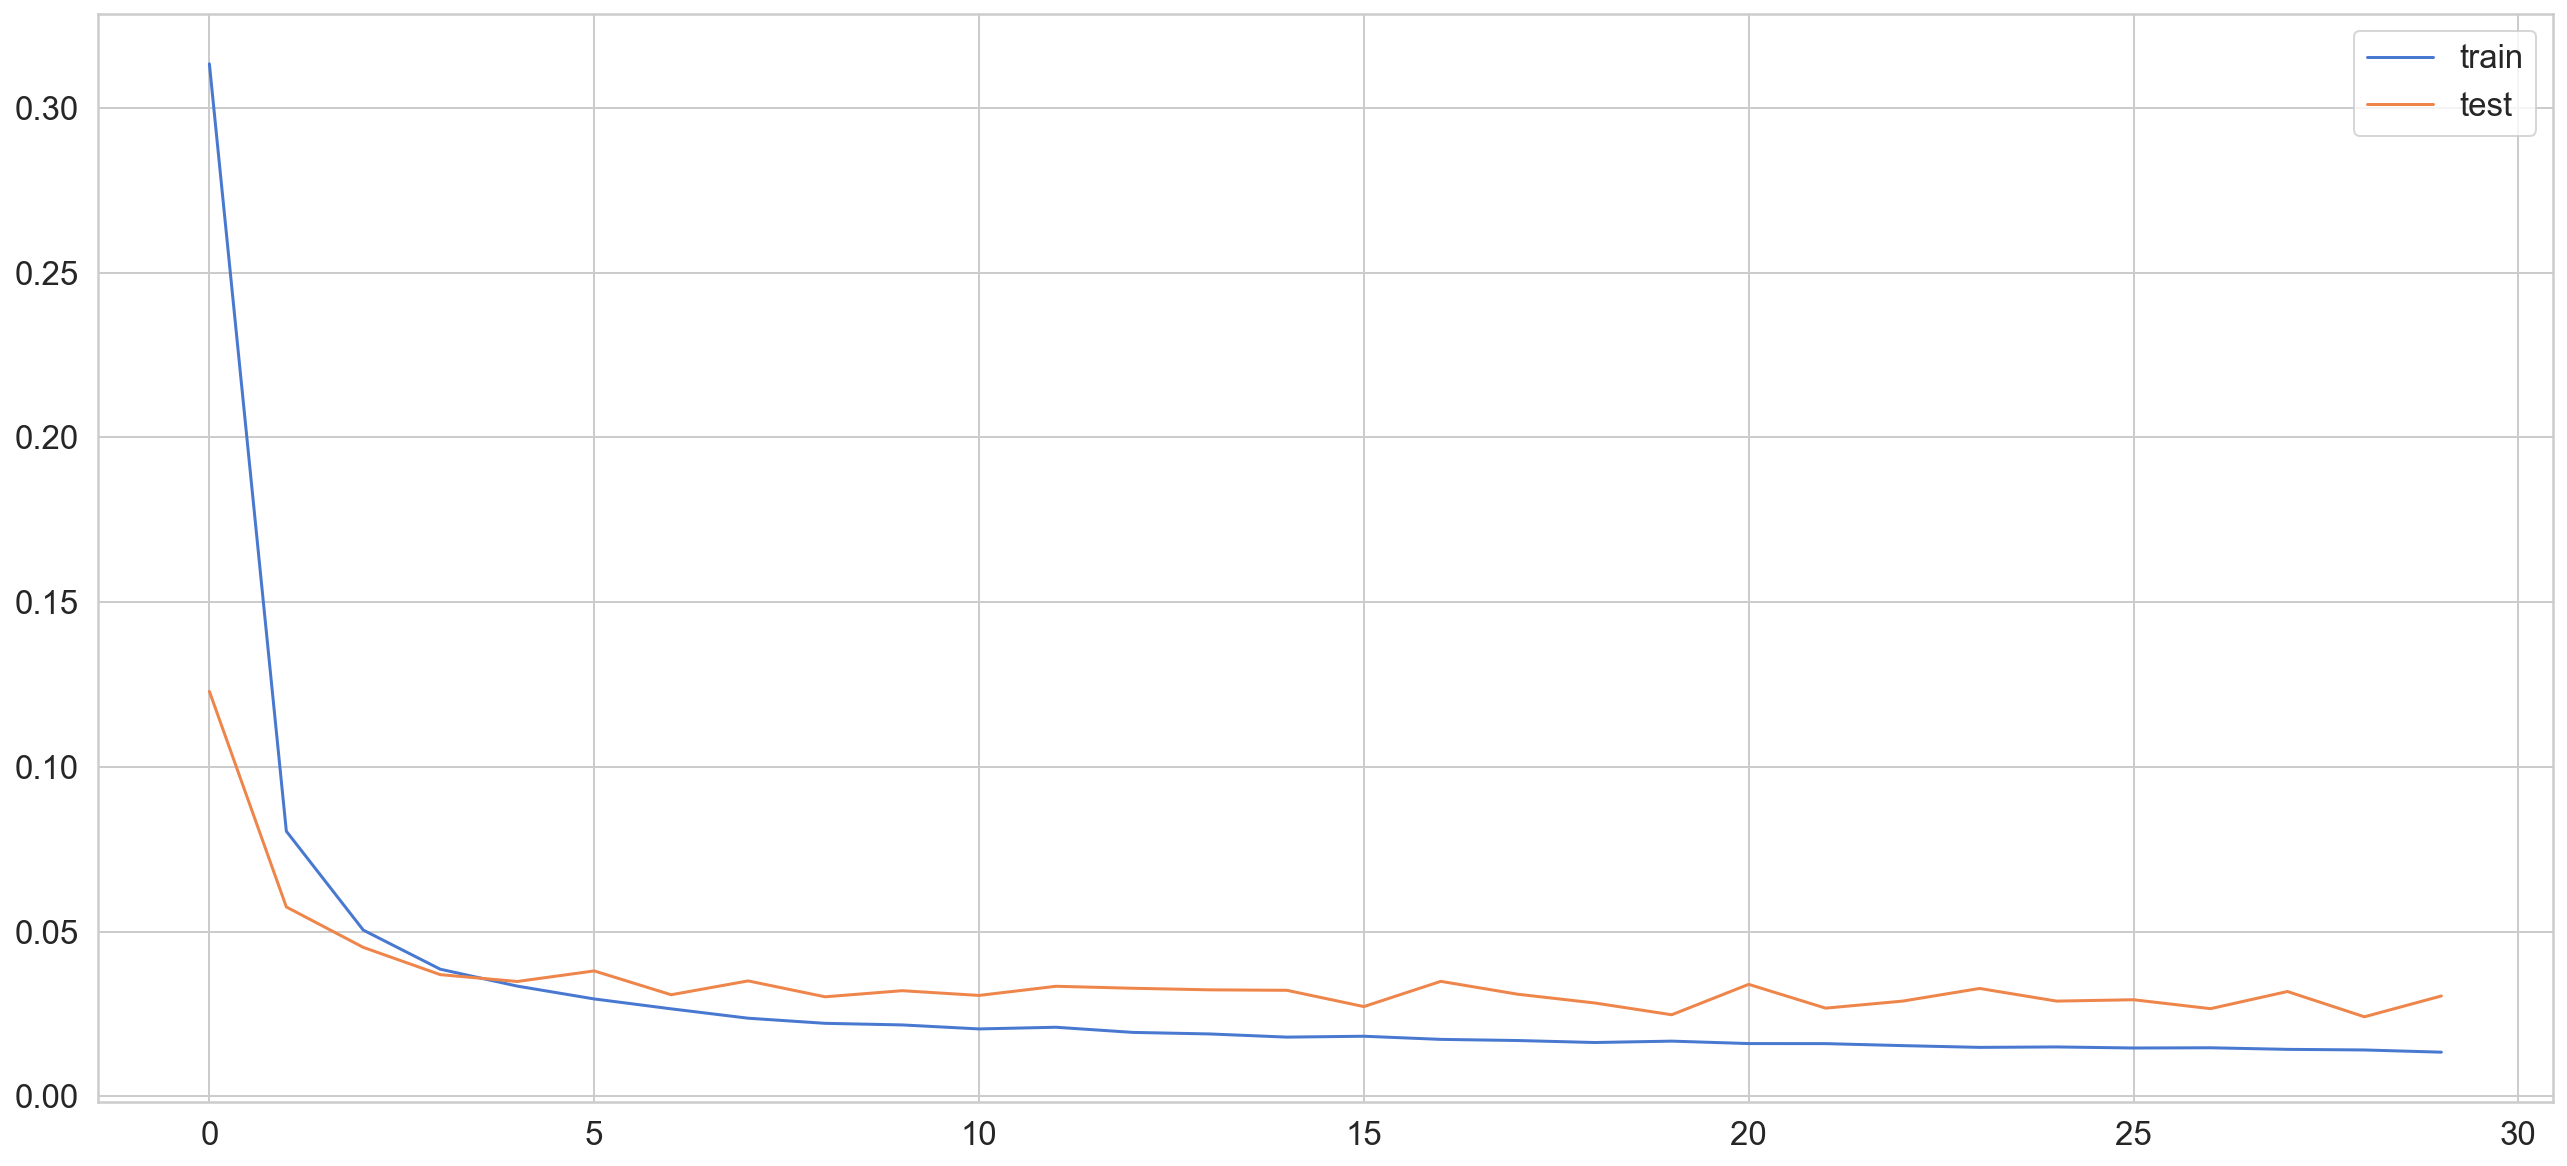

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [50]:
y_pred = model.predict(X_test) # predicat on the Test => whicht the Model not know this actually there


55/55 [==============================] - 1s 2ms/step


### Inverse Transform

In [51]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

**Visualizing the Performance**

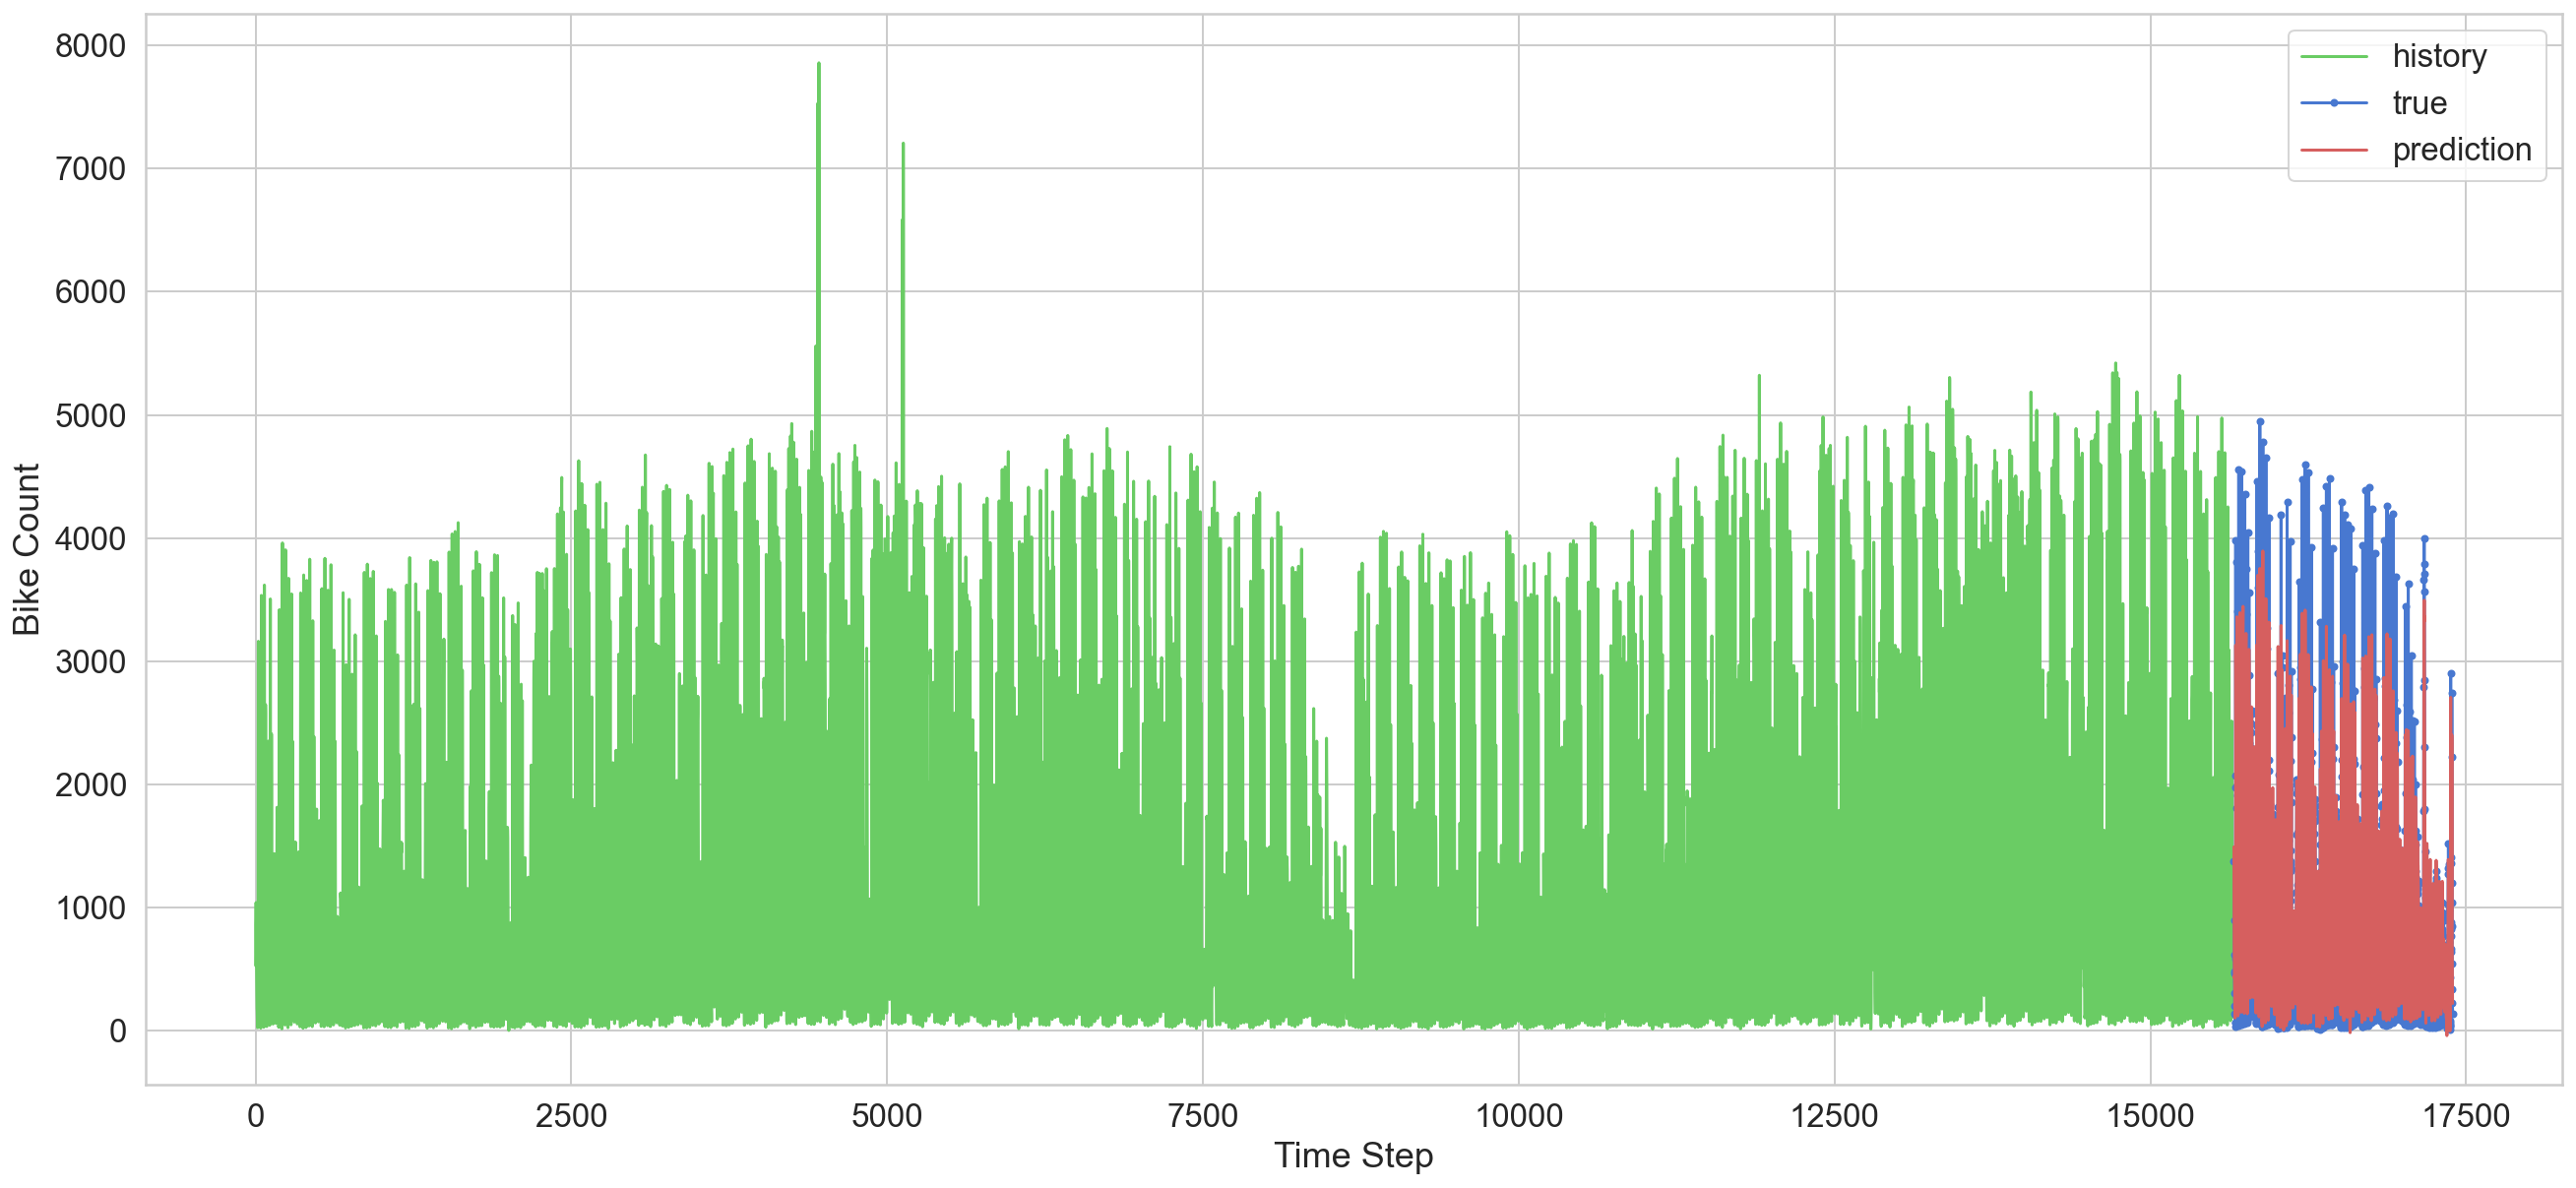

In [52]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

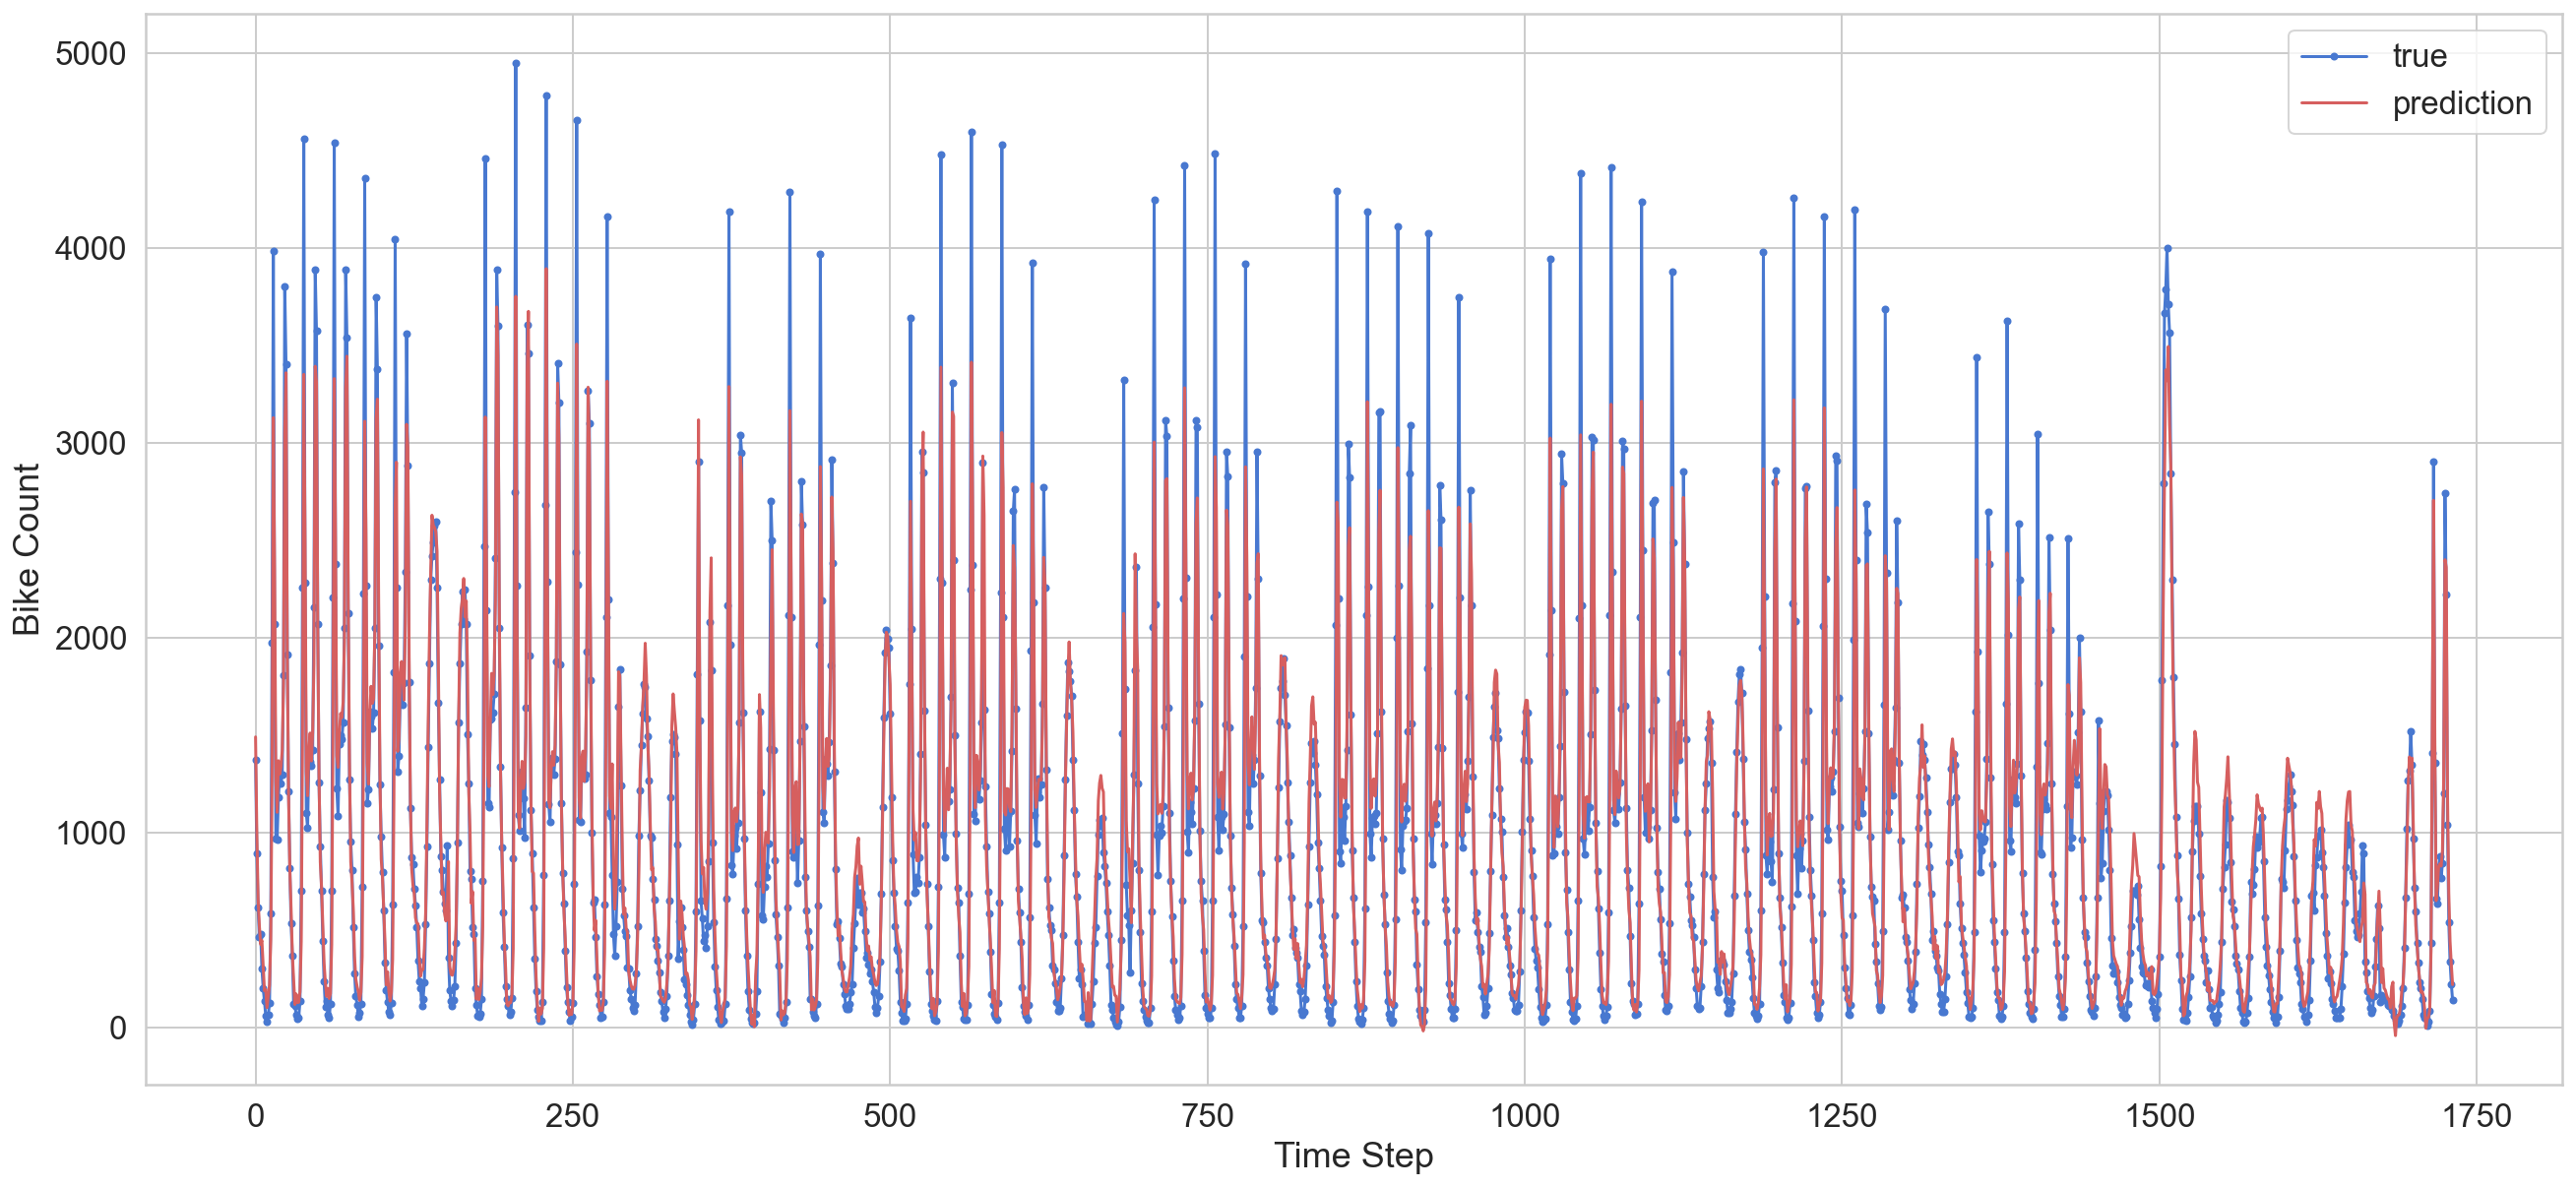

In [53]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute the mean squared error
mse = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())


# Compute the mean absolute error
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())

# Compute the coefficient of determination
r2 = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

# Print the results
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 70419.59
Mean Absolute Error: 153.42
R-squared: 0.92
